# MNIST Classification with Brevitas Quantization-Aware Training 

In this notebook, we show how to use [Brevitas](https://github.com/Xilinx/brevitas) to perform quantization-aware training on the famous [MNIST](http://yann.lecun.com/exdb/mnist/) dataset. We then show how the Virtual Library can be used to finetune parameters and find the best setting, before finally checking computations in FHE.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import onnx
import torch

# Concrete-Numpy and Concrete-ML
from concrete.numpy.compilation import Configuration

# The QAT model
from model import MNISTQATModel
from torch import nn, optim
from torch.optim.lr_scheduler import StepLR
from torchvision import datasets, transforms
from tqdm import tqdm

from concrete.ml.torch.compile import compile_torch_model

Using rdseed seeder.


Here are the functions to train and test the model. Everything is very classical here.

In [2]:
def train(model, device, train_loader, optimizer, epoch, criterion):
    """Train the model."""

    model.train()

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data).squeeze()
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        if batch_idx % 500 == 0:
            print(
                f"Train Epoch: {epoch} [{batch_idx}/{len(train_loader.dataset) // len(data)}"
                f" ({100.0 * batch_idx / len(train_loader):.0f}%)]"
                f"\tLoss: {loss.item():.6f}"
            )

In [3]:
def test(model, device, test_loader, criterion):
    """Test the model."""

    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in tqdm(test_loader):
            data, target = data.to(device), target.to(device)
            output = model(data).squeeze()
            test_loss += criterion(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print(
        f"Test set: Average loss: {test_loss:.4f}, "
        "Accuracy: "
        f"{correct}/{len(test_loader.dataset)} ({100.0 * correct / len(test_loader.dataset):.0f}%)"
    )

    return test_loss

In [4]:
def manage_dataset(train_kwargs, test_kwargs):
    """Get training and test parts of MNIST dataset."""

    # Pre-transform
    class ReshapeTransform:
        def __init__(self, new_size):
            self.new_size = new_size

        def __call__(self, img):
            return torch.reshape(img, self.new_size)

    transform = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,)),
            ReshapeTransform((28 * 28,)),
        ]
    )

    # Manage datasets
    dataset1 = datasets.MNIST("./data", train=True, download=True, transform=transform)
    dataset2 = datasets.MNIST("./data", train=False, transform=transform)
    train_loader = torch.utils.data.DataLoader(dataset1, **train_kwargs)
    test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)

    return train_loader, test_loader

The following function is used to test the model: it can be done either with the Virtual Library (i.e., without encryption) or in FHE. 

Checking things in VL is a very good habit to have within Concrete-ML since it allows to see the effect of the quantization on the accuracy, as well as to check the maximal bitwidth of intermediate values, without having to wait as long as when things are computed in FHE.

In [5]:
def compile_and_test(
    model,
    use_virtual_lib,
    np_inputs,
    quantization_bits,
    test_data,
    test_data_length,
    test_target,
    show_mlir,
    current_index,
):
    # Compile the QAT model and test
    configuration = Configuration(
        enable_unsafe_features=True,  # This is for our tests only, never use that in prod
        use_insecure_key_cache=True,  # This is for our tests only, never use that in prod
        insecure_key_cache_location="/tmp/keycache",
    )

    if use_virtual_lib:
        print(f"\n{current_index}. Compiling with the Virtual Library")
    else:
        print(f"\n{current_index}. Compiling in FHE")

    q_module = compile_torch_model(
        model,
        np_inputs,
        import_qat=True,
        configuration=configuration,
        # Note that in CML 0.4, fixing net_inputs and net_outputs to 5 will no more be needed,
        # since it will be the default
        n_bits={
            "net_inputs": 5,
            "op_inputs": quantization_bits,
            "op_weights": quantization_bits,
            "net_outputs": 5,
        },
        use_virtual_lib=use_virtual_lib,
        show_mlir=show_mlir,
    )

    # Check max bit width
    max_bit_width = q_module.forward_fhe.graph.maximum_integer_bit_width()

    if max_bit_width > 8:
        raise Exception(
            f"Too large bit-width ({max_bit_width}): training this network resulted in an "
            "accumulator size that is too large. Possible solutions are:"
            "    - this network should, on average, have 8bit accumulators. In your case an unlucky"
            f"initialization resulted in {max_bit_width} accumulators. You can try to train the "
            "network again"
            "    - reduce the sparsity to reduce the number of active neuron connexions"
            "    - if the weight and activation bitwidth is more than 2, you can try to reduce one "
            "or both to a lower value"
        )

    # Check the accuracy
    if use_virtual_lib:
        print(
            f"\n{current_index + 1}. Checking accuracy with the Virtual Library "
            f"(length {test_data_length})"
        )
    else:
        print(f"\n{current_index + 1}. Checking accuracy in FHE (length {test_data_length})")

    # Key generation
    if not use_virtual_lib:
        q_module.forward_fhe.keygen()

    correct_fhe = 0
    idx = 0

    # Reduce the test data, since very slow in FHE
    reduced_test_data = test_data[0:test_data_length, :]

    for idx, im in enumerate(tqdm(reduced_test_data)):
        target_np = test_target[idx]
        q_data = q_module.quantize_input(im)
        q_data = np.expand_dims(q_data, 0).astype(np.uint8)

        prediction = q_module.forward_fhe.encrypt_run_decrypt(q_data)
        prediction = q_module.dequantize_output(prediction)

        if np.argmax(prediction) == target_np:
            correct_fhe += 1

    # Final accuracy
    return correct_fhe, reduced_test_data.shape[0], max_bit_width

## Settings

Here, the user can change some settings. The most important ones are:
- epochs: how many epochs during the training
- sparsity: to define the number of active neurons in layers; make this value smaller and there will be less active neurons
- quantization_bits: the number of bits during quantization. The larger the more accurate, but also the faster we are above the limits of Concrete-ML in term of maximal bitwidth
- do_training: whether we do the training. If not, we use the previously saved ONNX model

In [6]:
# Options: the most important ones
epochs = 20
sparsity = 4
quantization_bits = 2
do_training = True

# Options: can be changed
lr = 0.02
gamma = 0.33
test_data_length_reduced = 2  # This is notably the length of the computation in FHE
test_data_length_full = 10000

# Options: no real reason to change
show_mlir = False
batch_size = 32
test_batch_size = 32
use_cuda_if_available = True
seed = None
criterion = nn.CrossEntropyLoss()

Seeding if we want to, to try to make everything as reproducible as possible.

In [7]:
# Seeding
if seed is None:
    seed = np.random.randint(0, 2**32 - 1)

print(f"\nUsing seed {seed}\n")
torch.manual_seed(seed);


Using seed 3108559580



Settings few things for the training.

In [8]:
# Training and test arguments
train_kwargs = {"batch_size": batch_size}
test_kwargs = {"batch_size": test_batch_size}

# Cuda management
use_cuda = torch.cuda.is_available() and use_cuda_if_available
device = torch.device("cuda" if use_cuda else "cpu")

if use_cuda:
    cuda_kwargs = {"num_workers": 1, "pin_memory": True, "shuffle": True}
    train_kwargs.update(cuda_kwargs)
    test_kwargs.update(cuda_kwargs)

Managing the MNIST dataset, and splitting it into a training and test part.

In [9]:
# Manage dataset
train_loader, test_loader = manage_dataset(train_kwargs, test_kwargs)

### Definining the model

The model is defined in `model.py`. You may want to have a look to this file to see how things work in Brevitas. You may also want to apply few changes here, to see what are the effects on the QAT training.

In [10]:
# Model definition
model = MNISTQATModel(quantization_bits, quantization_bits)
model = model.to(device)
model.prune(sparsity, True)

### Running the training

Below, we run the quantization-aware training, which can be quite slow.

Performing MNIST task with 2-bits in quantization and a sparsity of 4

1. Training
Train Epoch: 1 [0/1875 (0%)]	Loss: 5.305962
Train Epoch: 1 [500/1875 (27%)]	Loss: 0.918988
Train Epoch: 1 [1000/1875 (53%)]	Loss: 0.727811
Train Epoch: 1 [1500/1875 (80%)]	Loss: 0.441159


100%|███████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:03<00:00, 79.66it/s]
/Users/benoitchevalliermames/Documents/Zama/Git/concrete-ml-internal/.venv/lib/python3.9/site-packages/torch/nn/modules/module.py:1365: UserWarning: Positional args are being deprecated, use kwargs instead. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


Test set: Average loss: 0.0124, Accuracy: 8822/10000 (88%)
Train Epoch: 2 [0/1875 (0%)]	Loss: 0.422780
Train Epoch: 2 [500/1875 (27%)]	Loss: 0.711815
Train Epoch: 2 [1000/1875 (53%)]	Loss: 0.512439
Train Epoch: 2 [1500/1875 (80%)]	Loss: 0.069856


100%|██████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:03<00:00, 101.70it/s]


Test set: Average loss: 0.0105, Accuracy: 8959/10000 (90%)
Train Epoch: 3 [0/1875 (0%)]	Loss: 0.159041
Train Epoch: 3 [500/1875 (27%)]	Loss: 0.477454
Train Epoch: 3 [1000/1875 (53%)]	Loss: 0.492690
Train Epoch: 3 [1500/1875 (80%)]	Loss: 0.119687


100%|██████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:03<00:00, 100.44it/s]


Test set: Average loss: 0.0094, Accuracy: 9085/10000 (91%)
Train Epoch: 4 [0/1875 (0%)]	Loss: 0.139899
Train Epoch: 4 [500/1875 (27%)]	Loss: 0.416240
Train Epoch: 4 [1000/1875 (53%)]	Loss: 0.588317
Train Epoch: 4 [1500/1875 (80%)]	Loss: 0.074020


100%|██████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:03<00:00, 100.71it/s]


Test set: Average loss: 0.0087, Accuracy: 9163/10000 (92%)
Train Epoch: 5 [0/1875 (0%)]	Loss: 0.138318
Train Epoch: 5 [500/1875 (27%)]	Loss: 0.303529
Train Epoch: 5 [1000/1875 (53%)]	Loss: 0.401453
Train Epoch: 5 [1500/1875 (80%)]	Loss: 0.173679


100%|███████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:03<00:00, 99.31it/s]


Test set: Average loss: 0.0086, Accuracy: 9140/10000 (91%)
Train Epoch: 6 [0/1875 (0%)]	Loss: 0.118950
Train Epoch: 6 [500/1875 (27%)]	Loss: 0.401570
Train Epoch: 6 [1000/1875 (53%)]	Loss: 0.463107
Train Epoch: 6 [1500/1875 (80%)]	Loss: 0.195206


100%|██████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:03<00:00, 100.26it/s]


Test set: Average loss: 0.0086, Accuracy: 9161/10000 (92%)
Train Epoch: 7 [0/1875 (0%)]	Loss: 0.057101
Train Epoch: 7 [500/1875 (27%)]	Loss: 0.327124
Train Epoch: 7 [1000/1875 (53%)]	Loss: 0.423646
Train Epoch: 7 [1500/1875 (80%)]	Loss: 0.176952


100%|██████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:03<00:00, 100.46it/s]


Test set: Average loss: 0.0090, Accuracy: 9115/10000 (91%)
Train Epoch: 8 [0/1875 (0%)]	Loss: 0.210740
Train Epoch: 8 [500/1875 (27%)]	Loss: 0.476865
Train Epoch: 8 [1000/1875 (53%)]	Loss: 0.536574
Train Epoch: 8 [1500/1875 (80%)]	Loss: 0.104642


100%|██████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:03<00:00, 101.81it/s]


Test set: Average loss: 0.0087, Accuracy: 9124/10000 (91%)
Train Epoch: 9 [0/1875 (0%)]	Loss: 0.055264
Train Epoch: 9 [500/1875 (27%)]	Loss: 0.409403
Train Epoch: 9 [1000/1875 (53%)]	Loss: 0.504187
Train Epoch: 9 [1500/1875 (80%)]	Loss: 0.163340


100%|███████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:03<00:00, 90.96it/s]


Test set: Average loss: 0.0086, Accuracy: 9162/10000 (92%)
Train Epoch: 10 [0/1875 (0%)]	Loss: 0.115935
Train Epoch: 10 [500/1875 (27%)]	Loss: 0.522204
Train Epoch: 10 [1000/1875 (53%)]	Loss: 0.513674
Train Epoch: 10 [1500/1875 (80%)]	Loss: 0.141357


100%|███████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:03<00:00, 99.46it/s]


Test set: Average loss: 0.0085, Accuracy: 9151/10000 (92%)
Train Epoch: 11 [0/1875 (0%)]	Loss: 0.184956
Train Epoch: 11 [500/1875 (27%)]	Loss: 0.367457
Train Epoch: 11 [1000/1875 (53%)]	Loss: 0.456636
Train Epoch: 11 [1500/1875 (80%)]	Loss: 0.134292


100%|███████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:03<00:00, 99.94it/s]


Test set: Average loss: 0.0086, Accuracy: 9146/10000 (91%)
Train Epoch: 12 [0/1875 (0%)]	Loss: 0.100917
Train Epoch: 12 [500/1875 (27%)]	Loss: 0.479832
Train Epoch: 12 [1000/1875 (53%)]	Loss: 0.484519
Train Epoch: 12 [1500/1875 (80%)]	Loss: 0.143926


100%|███████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:04<00:00, 71.00it/s]


Test set: Average loss: 0.0088, Accuracy: 9126/10000 (91%)
Train Epoch: 13 [0/1875 (0%)]	Loss: 0.137374
Train Epoch: 13 [500/1875 (27%)]	Loss: 0.397918
Train Epoch: 13 [1000/1875 (53%)]	Loss: 0.570611
Train Epoch: 13 [1500/1875 (80%)]	Loss: 0.086632


100%|██████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:03<00:00, 100.31it/s]


Test set: Average loss: 0.0075, Accuracy: 9265/10000 (93%)
Train Epoch: 14 [0/1875 (0%)]	Loss: 0.153252
Train Epoch: 14 [500/1875 (27%)]	Loss: 0.405863
Train Epoch: 14 [1000/1875 (53%)]	Loss: 0.474483
Train Epoch: 14 [1500/1875 (80%)]	Loss: 0.131933


100%|███████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:03<00:00, 86.93it/s]


Test set: Average loss: 0.0075, Accuracy: 9263/10000 (93%)
Train Epoch: 15 [0/1875 (0%)]	Loss: 0.153252
Train Epoch: 15 [500/1875 (27%)]	Loss: 0.405863
Train Epoch: 15 [1000/1875 (53%)]	Loss: 0.474483
Train Epoch: 15 [1500/1875 (80%)]	Loss: 0.131933


100%|██████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:03<00:00, 101.48it/s]


Test set: Average loss: 0.0075, Accuracy: 9263/10000 (93%)
Train Epoch: 16 [0/1875 (0%)]	Loss: 0.153252
Train Epoch: 16 [500/1875 (27%)]	Loss: 0.405863
Train Epoch: 16 [1000/1875 (53%)]	Loss: 0.474483
Train Epoch: 16 [1500/1875 (80%)]	Loss: 0.131933


100%|██████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:03<00:00, 100.81it/s]


Test set: Average loss: 0.0075, Accuracy: 9263/10000 (93%)
Train Epoch: 17 [0/1875 (0%)]	Loss: 0.153252
Train Epoch: 17 [500/1875 (27%)]	Loss: 0.405863
Train Epoch: 17 [1000/1875 (53%)]	Loss: 0.474483
Train Epoch: 17 [1500/1875 (80%)]	Loss: 0.131933


100%|███████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:03<00:00, 92.53it/s]


Test set: Average loss: 0.0075, Accuracy: 9263/10000 (93%)
Train Epoch: 18 [0/1875 (0%)]	Loss: 0.153252
Train Epoch: 18 [500/1875 (27%)]	Loss: 0.405863
Train Epoch: 18 [1000/1875 (53%)]	Loss: 0.474483
Train Epoch: 18 [1500/1875 (80%)]	Loss: 0.131933


100%|██████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:03<00:00, 101.44it/s]


Test set: Average loss: 0.0075, Accuracy: 9263/10000 (93%)
Train Epoch: 19 [0/1875 (0%)]	Loss: 0.153252
Train Epoch: 19 [500/1875 (27%)]	Loss: 0.405863
Train Epoch: 19 [1000/1875 (53%)]	Loss: 0.474483
Train Epoch: 19 [1500/1875 (80%)]	Loss: 0.131933


100%|███████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:03<00:00, 95.56it/s]


Test set: Average loss: 0.0075, Accuracy: 9263/10000 (93%)
Train Epoch: 20 [0/1875 (0%)]	Loss: 0.153252
Train Epoch: 20 [500/1875 (27%)]	Loss: 0.405863
Train Epoch: 20 [1000/1875 (53%)]	Loss: 0.474483
Train Epoch: 20 [1500/1875 (80%)]	Loss: 0.131933


100%|██████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:03<00:00, 100.14it/s]


Test set: Average loss: 0.0075, Accuracy: 9263/10000 (93%)

2. Exporting to ONNX


/Users/benoitchevalliermames/Documents/Zama/Git/concrete-ml-internal/.venv/lib/python3.9/site-packages/brevitas/quant_tensor/__init__.py:94: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  x = torch.tensor(x, dtype=torch_dtype)


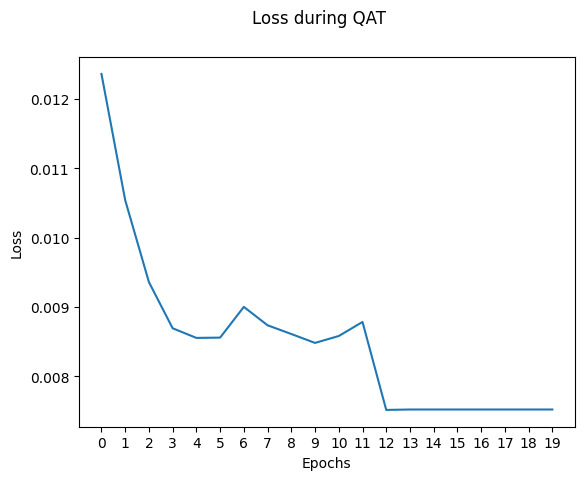

In [11]:
# Training part
print(
    f"Performing MNIST task with {quantization_bits}-bits in quantization and a "
    f"sparsity of {sparsity}"
)

if do_training:
    print("\n1. Training")
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=0.0001)
    scheduler = StepLR(optimizer, step_size=1, gamma=gamma)
    test_loss = 1e10
    loss_values = []

    for epoch in range(1, epochs + 1):
        train(model, device, train_loader, optimizer, epoch, criterion)
        cur_loss = test(model, device, test_loader, criterion)

        scheduler.step()

        loss_values.append(cur_loss)

    model.prune(sparsity, False)

    # Plot the loss
    fig = plt.figure()
    plt.plot(loss_values)
    fig.suptitle("Loss during QAT")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.xticks(range(len(loss_values)))

    # Export to ONNX
    print("\n2. Exporting to ONNX")
    inp = torch.rand((1, 784)).to(device)
    torch.onnx.export(model, inp, "mnist.qat.onnx", opset_version=14)

else:
    print("\n1. Loading pre-trained model")

Then, we reload the model, which is useful if we've set do_training = False to avoid to redo the training.

In [12]:
# Reload the model
model = onnx.load("mnist.qat.onnx")

We prepare the ground truth, for final check of the model.

In [13]:
# Prepare tests
list_inputs = []
list_targets = []

for inputs in test_loader:
    inputs_var, targets = inputs
    list_inputs.append(inputs_var.detach().cpu().numpy())
    list_targets.append(targets.detach().cpu().numpy())

np_inputs = np.concatenate(list_inputs, axis=0)
np_targets = np.concatenate(list_targets, axis=0)

test_data = np.zeros((len(test_loader.dataset), 784))
test_target = np.zeros((len(test_loader.dataset), 1))
idx = 0

for data, target in tqdm(test_loader):
    target_np = target.cpu().numpy()
    for idx_batch, im in enumerate(data.numpy()):
        test_data[idx] = im
        test_target[idx] = target_np[idx_batch]
        idx += 1

100%|██████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 208.36it/s]


### Measuring accuracy in VL and FHE

Finally, we measure:
- accuracy in VL for the full test set
- accuracy in VL for the reduced test set
- accuracy in FHE for the reduced test set   

and we check that accuracy in VL and in FHE are equivalent on the reduced test set. 

Running FHE computations on a too large reduced test set may be prohibitive since we're 100% on CPU for the time being. Later, we'll have HW accelerators, to make these computations several order of magnitude faster. 

In [14]:
# Test in the VL and in FHE
accuracy = {}
current_index = 3

for use_virtual_lib, use_full_dataset in [(True, True), (True, False), (False, False)]:
    test_data_length = test_data_length_full if use_full_dataset else test_data_length_reduced

    correct_fhe, test_data_shape_0, max_bit_width = compile_and_test(
        model,
        use_virtual_lib,
        np_inputs,
        quantization_bits,
        test_data,
        test_data_length,
        test_target,
        show_mlir,
        current_index,
    )

    current_index += 2
    current_accuracy = correct_fhe / test_data_shape_0

    print(
        f"Accuracy in {'VL' if use_virtual_lib else 'FHE'} with length {test_data_length}: "
        f"{correct_fhe}/{test_data_shape_0} = "
        f"{current_accuracy:.4f}, in {max_bit_width} bits"
    )

    if (use_virtual_lib, use_full_dataset) == (True, True):
        accuracy["VL full"] = current_accuracy
    elif (use_virtual_lib, use_full_dataset) == (True, False):
        accuracy["VL short"] = current_accuracy
    else:
        assert (use_virtual_lib, use_full_dataset) == (False, False)
        accuracy["FHE short"] = current_accuracy


3. Compiling with the Virtual Library

4. Checking accuracy with the Virtual Library (length 10000)


100%|██████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:58<00:00, 170.43it/s]


Accuracy in VL with length 10000: 9282/10000 = 0.9282, in 6 bits

5. Compiling with the Virtual Library

6. Checking accuracy with the Virtual Library (length 2)


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 117.30it/s]

Accuracy in VL with length 2: 2/2 = 1.0000, in 6 bits

7. Compiling in FHE



8. Checking accuracy in FHE (length 2)


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [08:43<00:00, 261.86s/it]

Accuracy in FHE with length 2: 2/2 = 1.0000, in 6 bits


In [15]:
# Check that accuracy in FHE and in VL is the same
assert (
    accuracy["VL short"] == accuracy["FHE short"]
), "Error, accuracy in VL and in FHE are not the same"

# Check that accuracy is random-looking
assert accuracy["VL full"] > 0.8, "Error, accuracy is too bad"

### Conclusion

We've shown how to train a model with Brevitas in quantization-aware training. Then, we've seen that its accuracy was pretty correct (92% is not too hard to obtain), even if lower than the state-of-the-art on cleartexts. 

Brevitas is not the only third-party package one can use for QAT. Other examples with other frameworks will certainly be added in our repository.
